# 다중 합성곱 감성 분류기

이 노트북에서 *다중 병렬 합성곱 층*의 출력을 연결하여 감성에 따라 IMDB 영화 리뷰를 분류합니다.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rickiepark/dl-illustrated/blob/master/notebooks/11-10.multi_convnet_sentiment_classifier.ipynb)

#### 라이브러리 적재

In [1]:
from tensorflow import keras
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model # new!
from tensorflow.keras.layers import Input, concatenate # new! 
from tensorflow.keras.layers import Dense, Dropout, Embedding, SpatialDropout1D, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
%matplotlib inline

#### 하이퍼파라미터 설정

In [2]:
# 출력 디렉토리
output_dir = 'model_output/multiconv'

# 훈련
epochs = 4
batch_size = 128

# 벡터 공간 임베딩
n_dim = 64
n_unique_words = 5000 
max_review_length = 400
pad_type = trunc_type = 'pre'
drop_embed = 0.2 

# 합성곱 층 구조
n_conv_1 = n_conv_2 = n_conv_3 = 256 
k_conv_1 = 3
k_conv_2 = 2
k_conv_3 = 4

# 밀집 층 구조
n_dense = 256
dropout = 0.2

#### 데이터 적재

In [3]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words) 

17473536/17464789 [==============================] - 0s 0us/step


#### 데이터 전처리

In [4]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

#### 신경망 만들기

In [5]:
input_layer = Input(shape=(max_review_length,), 
                    dtype='int16', name='input') 

# 임베딩 
embedding_layer = Embedding(n_unique_words, n_dim, 
                            name='embedding')(input_layer)
drop_embed_layer = SpatialDropout1D(drop_embed, 
                                    name='drop_embed')(embedding_layer)

# 3개의 병렬 합성곱 층
conv_1 = Conv1D(n_conv_1, k_conv_1, 
                activation='relu', name='conv_1')(drop_embed_layer)
maxp_1 = GlobalMaxPooling1D(name='maxp_1')(conv_1)

conv_2 = Conv1D(n_conv_2, k_conv_2, 
                activation='relu', name='conv_2')(drop_embed_layer)
maxp_2 = GlobalMaxPooling1D(name='maxp_2')(conv_2)

conv_3 = Conv1D(n_conv_3, k_conv_3, 
                activation='relu', name='conv_3')(drop_embed_layer)
maxp_3 = GlobalMaxPooling1D(name='maxp_3')(conv_3)

# 합성곱 층의 활성화 연결
concat = concatenate([maxp_1, maxp_2, maxp_3])

# 밀집 은닉층
dense_layer = Dense(n_dense, 
                    activation='relu', name='dense')(concat)
drop_dense_layer = Dropout(dropout, name='drop_dense')(dense_layer)
dense_2 = Dense(int(n_dense/4), 
                activation='relu', name='dense_2')(drop_dense_layer)
dropout_2 = Dropout(dropout, name='drop_dense_2')(dense_2)

# 출력층
predictions = Dense(1, activation='sigmoid', name='output')(dropout_2)

# 모델 생성
model = Model(input_layer, predictions)

In [6]:
model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 400)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 400, 64)      320000      input[0][0]                      
__________________________________________________________________________________________________
drop_embed (SpatialDropout1D)   (None, 400, 64)      0           embedding[0][0]                  
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 398, 256)     49408       drop_embed[0][0]                 
______________________________________________________________________________________________

#### 모델 설정

In [7]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### 훈련!

In [9]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Epoch 1/4
196/196 [==============================] - 41s 44ms/step - loss: 0.5069 - accuracy: 0.7158 - val_loss: 0.2926 - val_accuracy: 0.8788
Epoch 2/4
196/196 [==============================] - 8s 42ms/step - loss: 0.2521 - accuracy: 0.9012 - val_loss: 0.2723 - val_accuracy: 0.8852
Epoch 3/4
196/196 [==============================] - 8s 42ms/step - loss: 0.1766 - accuracy: 0.9348 - val_loss: 0.2797 - val_accuracy: 0.8934
Epoch 4/4
196/196 [==============================] - 8s 43ms/step - loss: 0.1234 - accuracy: 0.9582 - val_loss: 0.2933 - val_accuracy: 0.8935


#### 평가

In [10]:
model.load_weights(output_dir+"/weights.02.hdf5") 

In [11]:
y_hat = model.predict(x_valid)

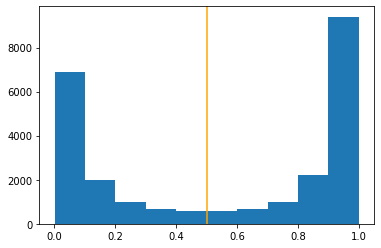

In [12]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [13]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'96.10'